In [ ]:
import numpy as np
import pickle as pickle
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
# import pyeeg as pe
import pywt
import pickle
from itertools import cycle

from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical 
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
#For displaying in decimal in numpy and not scientific notation
np.set_printoptions(suppress=True)

In [ ]:
!git clone https://github.com/forrestbao/pyeeg

fatal: destination path 'pyeeg' already exists and is not an empty directory.


In [ ]:
import pyeeg as pe

In [ ]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    
    if (valence > 5 and arousal > 5):
        label = 1,1 #'HVHA'
    elif (valence > 5 and arousal <= 5):
        label = 1,0 #'HVLA'
    elif (valence <= 5 and arousal > 5):
        label = 0,1 #'LVHA'
    elif (valence <= 5 and arousal <= 5):
        label = 0,0 #'LVLA'
    
    return label

In [ ]:
def map_label(label):
    #print(label)
    new_label = label_mapping(label[0], label[1]) 
    return new_label

In [ ]:
def fft(X, Band, Fs):
  # PYEEG library's bin_power function
  C = np.fft.fft(X)
  C = abs(C)
  Power = np.zeros(len(Band) - 1)
  for Freq_Index in range(0, len(Band) - 1):
      Freq = float(Band[Freq_Index])
      Next_Freq = float(Band[Freq_Index + 1])
      Power[Freq_Index] = sum(
          C[int(np.floor(Freq / Fs * len(X))): 
              int(np.floor(Next_Freq / Fs * len(X)))]
      )
  Power_Ratio = Power / sum(Power)
  return Power, Power_Ratio

In [ ]:
channel = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
channel_test = [0, 16] # Fp1, Fp2

window_size = 512 #Averaging band power of 2 sec
step_size = 32 #256 #Each 1 sec update once 
subject_list=['01','02','03','04','05','06','07','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','25','26','27','29','30'
    ,'31','33','34','35','36','37','38','39','40']




In [ ]:
import scipy.io

In [ ]:
!mkdir amigos_epoched1

mkdir: cannot create directory ‘amigos_epoched1’: File exists


In [ ]:
def epoching (sub, channel, window_size, step_size, band, sample_rate):
        subject=scipy.io.loadmat('/content/drive/MyDrive/Data/'+ "Data_Preprocessed_P"+sub+"/Data_Preprocessed_P"+sub+"/Data_Preprocessed_P"+sub+ '.mat')
        signal = []
        for i in range (0,20):
            # loop over 0-39 trials
            data = subject['joined_data'][0][i]
            labels = subject['labels_selfassessment'][0][i][0]
            #print(labels)
            valence,arousal = map_label(labels)
            labels_v = np.array(valence)
            labels_a = np.array(arousal)
            # print(valence,arousal)
            start = 0;
            
            #print(data.shape[0])
            data=np.array(data)
            while start + window_size < data.shape[0]:
                meta_array = []
                meta_data = []
                for j in channel:
                    X=[]
                    for k in range(start,start+window_size):
                      X .append(data[k][j])
                    #X=data[start:start+window_size][j]
                    #print(len(X)) 
                    Y = fft(X,band,sample_rate)
                    #print(X.shape)
                    meta_data=meta_data+list(Y[0])
                    #meta_data.append(np.array(X).ravel())
                    #meta_data=np.array(meta_data).ravel()

                meta_array.append(np.array(meta_data))
                meta_array.append(labels_v)
                meta_array.append(labels_a)
                signal.append(np.array(meta_array, dtype=object))
                start = start + step_size
                # print(signal)
                
        signal = np.array(signal)
        #print(signal)
        np.save('/content/amigos_epoched1/s' + sub, signal, allow_pickle=True, fix_imports=True)


In [ ]:
band=[4, 8, 12, 16, 25, 45]
sample_rate=128
for subjects in subject_list:
    epoching (subjects, channel, window_size, step_size, band, sample_rate)
    print(subjects)

01
02
03
04
05
06
07
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
29
30
31
33
34
35
36
37
38
39
40


In [ ]:
data = []
label_v = []
label_a=[]

for subjects in subject_list:
  with open('/content/amigos_epoched1/s' + subjects + '.npy', 'rb') as file:
            sub = np.load(file,allow_pickle=True)
            #print(sub)
            for i in range (0,sub.shape[0]):

              data.append(sub[i][0].ravel())
              #label.append(sub[i][1])
              label_v.append(sub[i][1].item())
              label_a.append(sub[i][2].item())


np.save('/content/drive/MyDrive/eegEmotionDetection/amigos_combined/data_valence_arousal_binary_classif_1', np.array(data), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/eegEmotionDetection/amigos_combined/label_valence_binary_classif_1', np.array(label_v), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/eegEmotionDetection/amigos_combined/label_arousal_binary_classif_1', np.array(label_a), allow_pickle=True, fix_imports=True)

print("Training datasets:", np.array(data).shape, np.array(label_v).shape)

Training datasets: (893556, 70) (893556,)


In [ ]:
with open('/content/drive/MyDrive/eegEmotionDetection/amigos_combined/data_valence_arousal_binary_classif_1.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)
    
with open('/content/drive/MyDrive/eegEmotionDetection/amigos_combined/label_valence_binary_classif_1.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)


In [ ]:
print(data.shape)
print(label_v.shape)
print(label_a.shape)

(893556, 70)


NameError: ignored

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)
x_train, x, y_train, y = train_test_split(data, label, test_size=0.4, random_state=12)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=12)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(536133, 70)
(536133,)
(178711, 70)
(178711,)
(178712, 70)
(178712,)


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_val, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_test, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 194436, 1: 341697}
{0: 64752, 1: 113959}
{0: 64914, 1: 113798}


In [ ]:
scaler = StandardScaler()

In [ ]:
x_train= np.nan_to_num(x_train) 

In [ ]:
x_test= np.nan_to_num(x_test) 
x_val= np.nan_to_num(x_val) 

In [ ]:
# 4 Normalization -> Standardization 
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.transform(normalize(x_val))
x_test = scaler.transform(normalize(x_test))


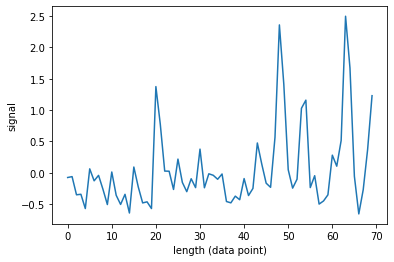

In [ ]:
plt.plot(x_train[0])
# plt.title("Epoched Data Sample")
plt.ylabel('signal')
plt.xlabel('length (data point)')
plt.show()

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(536133, 70, 1)
(178711, 70, 1)
(178712, 70, 1)
(536133,)
(178711,)
(178712,)


In [ ]:
batch_size = 256
num_classes = 2
epochs = 100
factor = 0.01
rate = 0.2
input_shape=(x_train.shape[1],x_train.shape[2])


In [ ]:
#GPU info
!nvidia-smi

Fri Jul  1 15:10:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |   5116MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model_lstm = Sequential()

model_lstm.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
model_lstm.add(MaxPooling1D(pool_size=2))
model_lstm.add(Dropout(rate))

model_lstm.add(Conv1D(128, 1, activation='relu'))
model_lstm.add(MaxPooling1D(pool_size=2))
model_lstm.add(Dropout(rate))

model_lstm.add(Conv1D(256, 1, activation='relu'))
model_lstm.add(MaxPooling1D(pool_size=2))
model_lstm.add(Dropout(rate))

model_lstm.add(LSTM(units = 256, return_sequences=True))  
model_lstm.add(Dropout(rate))

model_lstm.add(LSTM(units = 128, return_sequences=True))
model_lstm.add(Dropout(rate))

model_lstm.add(LSTM(units = 64))
model_lstm.add(Dropout(rate))

# model_lstm.add(Flatten())

model_lstm.add(Dense(units = 32, activation='relu'))
model_lstm.add(Dropout(rate))

model_lstm.add(Dense(units = 1))
model_lstm.add(Activation('sigmoid'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 70, 64)            128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 35, 64)           0         
 1D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 35, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 35, 128)           8320      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 17, 128)          0         
 1D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 17, 128)          

In [ ]:
model_lstm.compile(
    optimizer =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=2.5e-5, mode='min')

In [ ]:
history_lstm = model_lstm.fit(
    x_train, 
    y_train,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),callbacks=[reduce_lr]
)

Epoch 1/50
2095/2095 [==============================] - 123s 14ms/step - loss: 0.6050 - accuracy: 0.6741 - val_loss: 0.4497 - val_accuracy: 0.7821 - lr: 0.0010
Epoch 2/50
2095/2095 [==============================] - 29s 14ms/step - loss: 0.3972 - accuracy: 0.8129 - val_loss: 0.3154 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 3/50
2095/2095 [==============================] - 29s 14ms/step - loss: 0.3142 - accuracy: 0.8575 - val_loss: 0.2592 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 4/50
2095/2095 [==============================] - 29s 14ms/step - loss: 0.2723 - accuracy: 0.8787 - val_loss: 0.2288 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 5/50
2095/2095 [==============================] - 29s 14ms/step - loss: 0.2443 - accuracy: 0.8925 - val_loss: 0.2262 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 6/50
2095/2095 [==============================] - 29s 14ms/step - loss: 0.2220 - accuracy: 0.9034 - val_loss: 0.1997 - val_accuracy: 0.9139 - lr: 0.0010
Epoch 7/50
2095/2095 [=======================

In [ ]:
score_lstm = model_lstm.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_lstm[0])
print('Test accuracy:', score_lstm[1])

5585/5585 [==============================] - 25s 5ms/step - loss: 0.1146 - accuracy: 0.9605
Test loss: 0.1146375834941864
Test accuracy: 0.9604671001434326


In [ ]:
model_lstm.save('/content/drive/MyDrive/eegEmotionDetection/trained_models/model_lstm_valence_classif.h5')

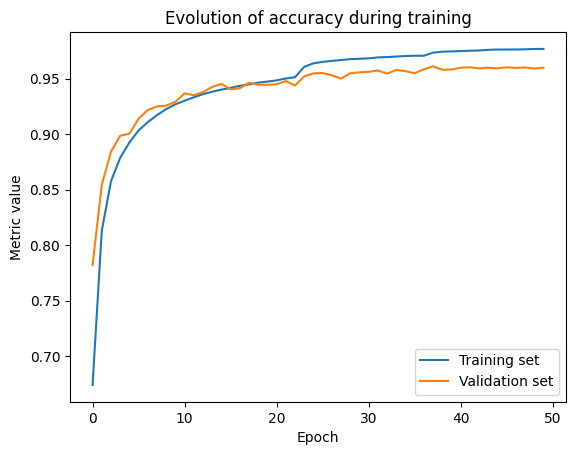

In [ ]:
plt.style.use('default')
plt.plot(range(50),history_lstm.history['accuracy'],label='Training set')
plt.plot(range(50),history_lstm.history['val_accuracy'], label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Evolution of accuracy during training')
plt.legend()

In [ ]:
y_pred_prob = model_lstm.predict(x_test, verbose=1)
y_pred = (y_pred_prob>0.5)*1 #or greater than equal to?

5585/5585 [==============================] - 23s 4ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred)
print('Acc :',acc)
f1 = f1_score(y_test, y_pred)
print('F1 :',f1)
precision = precision_score(y_test, y_pred)
print('Precision :',precision)
recall = recall_score(y_test, y_pred)
print('Recall :',recall)
# classLabels = np.unique(np.argmax(y_train,axis=1))
f1_scores = f1_score(y_test, y_pred)
# f1_scores_with_labels = {label:score for label,score in zip(classLabels, f1_scores)}
# print('Classwise F1 :\n',f1_scores_with_labels)
# classLabels = ['0','1']
cnfMatrix = confusion_matrix(y_test, y_pred) #change
print('Confusion Matrix :\n',cnfMatrix)

Acc : 0.9604671202829133
F1 : 0.9691852071547892
Precision : 0.9621476510067114
Recall : 0.9763264732244855
Confusion Matrix :
 [[ 60543   4371]
 [  2694 111104]]


In [ ]:
tn, fp, fn, tp = cnfMatrix.ravel()
(tn, fp, fn, tp)

(60543, 4371, 2694, 111104)

Text(0.5, 1.0, 'Confusion Matrix')

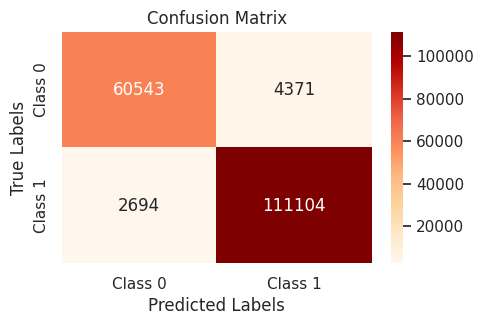

In [ ]:
df_cm = pd.DataFrame(cnfMatrix, ['Class 0','Class 1'], ['Class 0','Class 1'])
fig=plt.figure(figsize=(5,3))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},fmt='g', cmap="OrRd") # font size
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

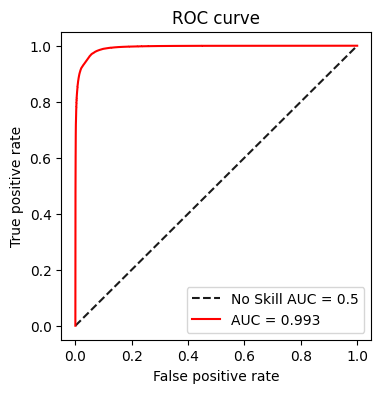

In [ ]:
plt.style.use('default')
plt.figure(figsize=(4,4))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_val = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_val), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model_gru = Sequential()

model_gru.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
model_gru.add(MaxPooling1D(pool_size=2))
model_gru.add(Dropout(rate))

model_gru.add(Conv1D(128, 3, activation='relu'))
model_gru.add(MaxPooling1D(pool_size=2))
model_gru.add(Dropout(rate))

model_gru.add(Conv1D(256, 3, activation='relu'))
model_gru.add(MaxPooling1D(pool_size=2))
model_gru.add(Dropout(rate))

model_gru.add(GRU(units = 256, return_sequences=True))  
model_gru.add(Dropout(rate))

model_gru.add(GRU(units = 128, return_sequences=True))
model_gru.add(Dropout(rate))

model_gru.add(GRU(units = 64))
model_gru.add(Dropout(rate))

# model_gru.add(Flatten())

model_gru.add(Dense(units = 32, activation='relu'))
model_gru.add(Dropout(rate))

model_gru.add(Dense(units = 1))
model_gru.add(Activation('sigmoid'))

model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 68, 64)            256       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 34, 64)           0         
 1D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 34, 64)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 32, 128)           24704     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 16, 128)          0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 16, 128)          

In [ ]:
model_gru.compile(
    optimizer =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=2.5e-5, mode='min')

In [ ]:
history_gru = model_gru.fit(
    x_train, 
    y_train,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val), #,
    callbacks=[reduce_lr]
    # callbacks=[
    #     keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=20,
    #         restore_best_weights=True
    #     )
    # ]
)

Epoch 1/50
2095/2095 [==============================] - 37s 15ms/step - loss: 0.4674 - accuracy: 0.7681 - val_loss: 0.3083 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 2/50
2095/2095 [==============================] - 28s 13ms/step - loss: 0.3237 - accuracy: 0.8520 - val_loss: 0.2330 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 3/50
2095/2095 [==============================] - 28s 13ms/step - loss: 0.2624 - accuracy: 0.8838 - val_loss: 0.1852 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 4/50
2095/2095 [==============================] - 29s 14ms/step - loss: 0.2208 - accuracy: 0.9036 - val_loss: 0.1566 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 5/50
2095/2095 [==============================] - 28s 13ms/step - loss: 0.1936 - accuracy: 0.9172 - val_loss: 0.1336 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 6/50
2095/2095 [==============================] - 28s 13ms/step - loss: 0.1748 - accuracy: 0.9260 - val_loss: 0.1177 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 7/50
2095/2095 [========================

In [ ]:
model_gru.save('/content/drive/MyDrive/eegEmotionDetection/trained_models/model_gru_valence_classif.h5')

In [ ]:
score_gru = model_gru.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_gru[0])
print('Test accuracy:', score_gru[1])

5585/5585 [==============================] - 24s 4ms/step - loss: 0.0380 - accuracy: 0.9859
Test loss: 0.03802471235394478
Test accuracy: 0.9859046936035156


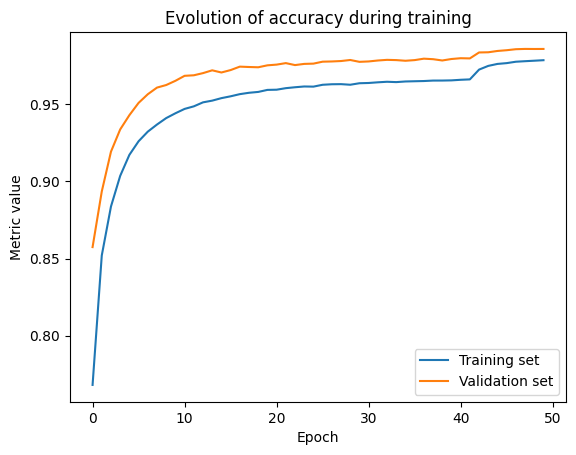

In [ ]:
plt.style.use('default')
plt.plot(range(50),history_gru.history['accuracy'],label='Training set')
plt.plot(range(50),history_gru.history['val_accuracy'], label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Evolution of accuracy during training')
plt.legend()

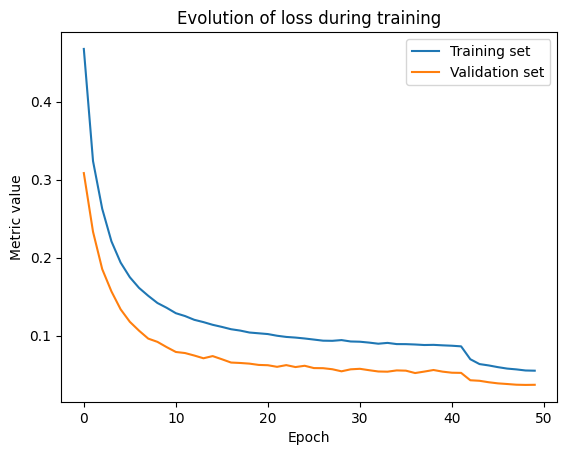

In [ ]:
plt.style.use('default')
plt.plot(range(50),history_gru.history['loss'], label='Training set')
plt.plot(range(50),history_gru.history['val_loss'], label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Evolution of loss during training')
plt.legend()

In [ ]:
y_pred_prob = model_gru.predict(x_test, verbose=1)
y_pred = (y_pred_prob>0.5)*1 #or greater than equal to?

5585/5585 [==============================] - 20s 3ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred)
print('Acc :',acc)
f1 = f1_score(y_test, y_pred)
print('F1 :',f1)
precision = precision_score(y_test, y_pred)
print('Precision :',precision)
recall = recall_score(y_test, y_pred)
print('Recall :',recall)
# classLabels = np.unique(np.argmax(y_train,axis=1))
f1_scores = f1_score(y_test, y_pred)
# f1_scores_with_labels = {label:score for label,score in zip(classLabels, f1_scores)}
# print('Classwise F1 :\n',f1_scores_with_labels)
# classLabels = ['0','1']
cnfMatrix = confusion_matrix(y_test, y_pred) #change
print('Confusion Matrix :\n',cnfMatrix)

Acc : 0.9859046958234478
F1 : 0.9889519966667397
Precision : 0.987181171031548
Recall : 0.990729186804689
Confusion Matrix :
 [[ 63450   1464]
 [  1055 112743]]


In [ ]:
tn, fp, fn, tp = cnfMatrix.ravel()
(tn, fp, fn, tp)

(63450, 1464, 1055, 112743)

Text(0.5, 1.0, 'Confusion Matrix')

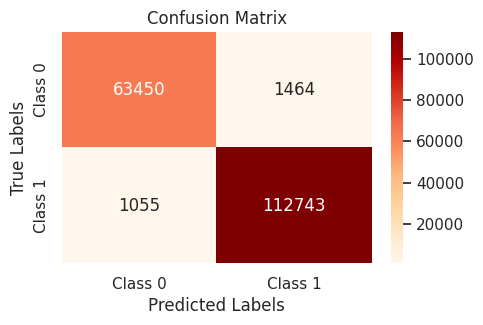

In [ ]:
df_cm = pd.DataFrame(cnfMatrix, ['Class 0','Class 1'], ['Class 0','Class 1'])
fig=plt.figure(figsize=(5,3))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},fmt='g', cmap="OrRd") # font size
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

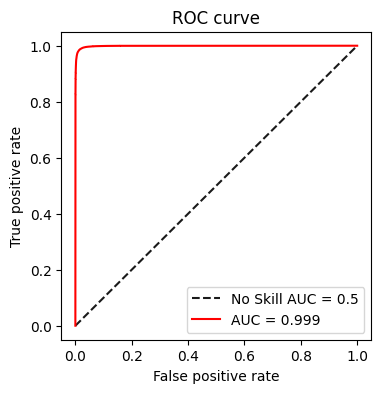

In [ ]:
plt.style.use('default')
plt.figure(figsize=(4,4))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_val = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_val), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(rate))

model_cnn.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(rate))

model_cnn.add(Conv1D(256, 3, activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(rate))

model_cnn.add(Conv1D(512, 3, activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(rate))

model_cnn.add(Flatten())

model_cnn.add(Dense(units = 512, activation='relu'))
model_cnn.add(Dropout(rate))

model_cnn.add(Dense(units = 256, activation='relu'))
model_cnn.add(Dropout(rate))

model_cnn.add(Dense(units = 128, activation='relu'))
model_cnn.add(Dropout(rate))

model_cnn.add(Dense(units = 1))
model_cnn.add(Activation('sigmoid'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 68, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 34, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 128)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0

In [ ]:
model_cnn.compile(
    optimizer =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=2.5e-5, mode='min')

In [ ]:
history_cnn = model_cnn.fit(
    x_train, 
    y_train,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val), #,
    callbacks=[reduce_lr]
    # callbacks=[
    #     keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=20,
    #         restore_best_weights=True
    #     )
    # ]
)

Epoch 1/50
2095/2095 [==============================] - 37s 11ms/step - loss: 0.4194 - accuracy: 0.7958 - val_loss: 0.2618 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 2/50
2095/2095 [==============================] - 23s 11ms/step - loss: 0.2867 - accuracy: 0.8699 - val_loss: 0.1991 - val_accuracy: 0.9121 - lr: 0.0010
Epoch 3/50
2095/2095 [==============================] - 26s 12ms/step - loss: 0.2444 - accuracy: 0.8910 - val_loss: 0.1701 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 4/50
2095/2095 [==============================] - 24s 11ms/step - loss: 0.2177 - accuracy: 0.9037 - val_loss: 0.1527 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 5/50
2095/2095 [==============================] - 24s 12ms/step - loss: 0.2006 - accuracy: 0.9119 - val_loss: 0.1380 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 6/50
2095/2095 [==============================] - 24s 11ms/step - loss: 0.1870 - accuracy: 0.9183 - val_loss: 0.1289 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 7/50
2095/2095 [========================

In [ ]:
model_cnn.save('/content/drive/MyDrive/eegEmotionDetection/trained_models/model_cnn_valence_classif.h5')

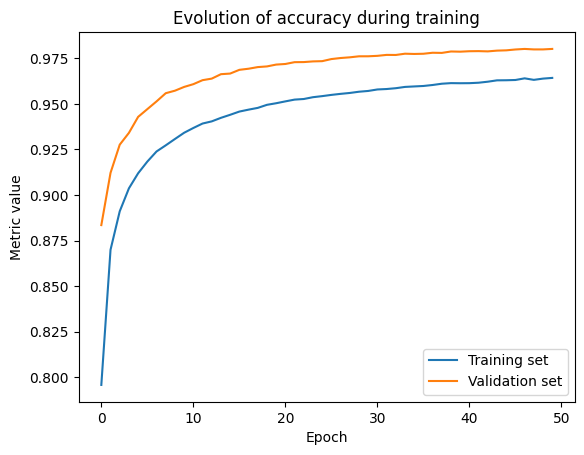

In [ ]:
plt.style.use('default')
plt.plot(range(50),history_cnn.history['accuracy'],label='Training set')
plt.plot(range(50),history_cnn.history['val_accuracy'], label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Evolution of accuracy during training')
plt.legend()

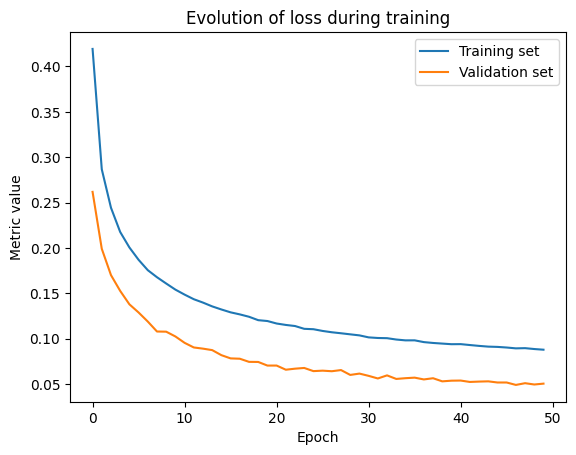

In [ ]:
plt.style.use('default')
plt.plot(range(50),history_cnn.history['loss'], label='Training set')
plt.plot(range(50),history_cnn.history['val_loss'], label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Evolution of loss during training')
plt.legend()

In [ ]:
y_pred_prob = model_cnn.predict(x_test, verbose=1)
y_pred = (y_pred_prob>0.5)*1 #or greater than equal to?

5585/5585 [==============================] - 12s 2ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred)
print('Acc :',acc)
f1 = f1_score(y_test, y_pred)
print('F1 :',f1)
precision = precision_score(y_test, y_pred)
print('Precision :',precision)
recall = recall_score(y_test, y_pred)
print('Recall :',recall)
# classLabels = np.unique(np.argmax(y_train,axis=1))
f1_scores = f1_score(y_test, y_pred)
# f1_scores_with_labels = {label:score for label,score in zip(classLabels, f1_scores)}
# print('Classwise F1 :\n',f1_scores_with_labels)
# classLabels = ['0','1']
cnfMatrix = confusion_matrix(y_test, y_pred) #change
print('Confusion Matrix :\n',cnfMatrix)

Acc : 0.9800572988943104
F1 : 0.9844598895971955
Precision : 0.977021740635602
Recall : 0.9920121619009121
Confusion Matrix :
 [[ 62259   2655]
 [   909 112889]]


In [ ]:
tn, fp, fn, tp = cnfMatrix.ravel()
(tn, fp, fn, tp)

(62259, 2655, 909, 112889)

Text(0.5, 1.0, 'Confusion Matrix')

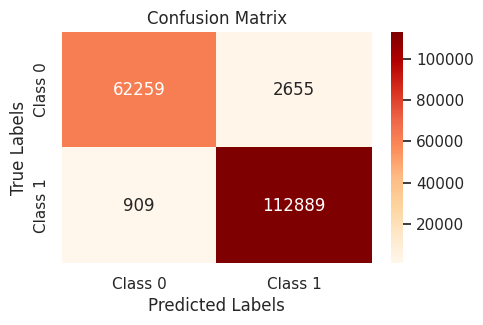

In [ ]:
df_cm = pd.DataFrame(cnfMatrix, ['Class 0','Class 1'], ['Class 0','Class 1'])
fig=plt.figure(figsize=(5,3))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},fmt='g', cmap="OrRd") # font size
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

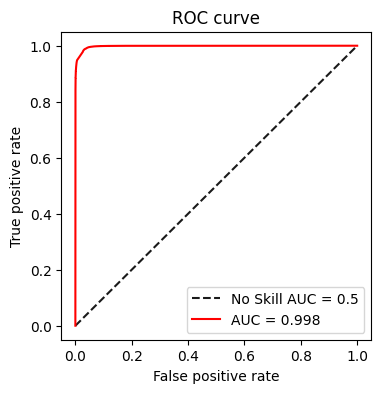

In [ ]:
plt.style.use('default')
plt.figure(figsize=(4,4))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_val = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_val), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model_lstm = tf.keras.models.load_model('/content/drive/MyDrive/eegEmotionDetection/trained_models/model_lstm_valence_classif.h5')
model_gru = tf.keras.models.load_model('/content/drive/MyDrive/eegEmotionDetection/trained_models/model_gru_valence_classif.h5')
model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/eegEmotionDetection/trained_models/model_cnn_valence_classif.h5')

In [ ]:
y_pred_prob_lstm = model_lstm.predict(x_test, verbose=1)
y_pred_lstm = (y_pred_prob_lstm>0.5)*1

5585/5585 [==============================] - 25s 4ms/step


In [ ]:
y_pred_prob_gru = model_gru.predict(x_test, verbose=1)
y_pred_gru = (y_pred_prob_gru>0.5)*1

5585/5585 [==============================] - 21s 4ms/step


In [ ]:
y_pred_prob_cnn = model_cnn.predict(x_test, verbose=1)
y_pred_cnn = (y_pred_prob_cnn>0.5)*1

5585/5585 [==============================] - 12s 2ms/step


In [ ]:
def fuzzy_rank(CF, top):
    R_L = np.zeros(CF.shape)
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            for k in range(CF.shape[2]):
                R_L[i][j][k] = 1 - math.exp(-math.exp(-2.0*CF[i][j][k]))  #Gompertz Function
    
    K_L = 0.632*np.ones(shape = R_L.shape) #initiate all values as penalty values
    for i in range(R_L.shape[0]):
        for sample in range(R_L.shape[1]):
            for k in range(top):
                a = R_L[i][sample]
                idx = np.where(a==np.partition(a, k)[k])
                #if sample belongs to top 'k' classes, R_L =R_L, else R_L = penalty value
                K_L[i][sample][idx] = R_L[i][sample][idx]

    return K_L

def CFS_func(CF, K_L):
    H = CF.shape[0] #no. of classifiers
    for f in range(CF.shape[0]):
        for i in range(CF.shape[1]):
            idx = np.where(K_L[f][i] == 0.632)
            CF[f][i][idx] = 0
    CFS = 1 - np.sum(CF,axis=0)/H
    return CFS

def Gompertz(top = 2, *argv):
    L = 0 #Number of classifiers
    for arg in argv:
        L += 1

    num_classes = arg.shape[1]
    CF = np.zeros(shape = (L,arg.shape[0], arg.shape[1]))

    for i, arg in enumerate(argv):
        CF[:][:][i] = arg

    R_L = fuzzy_rank(CF, top) #R_L is with penalties
    
    RS = np.sum(R_L, axis=0)
    CFS = CFS_func(CF, R_L)
    FS = RS*CFS

    predictions = np.argmin(FS,axis=1)
    return predictions

In [ ]:
def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

In [ ]:
p1 = y_pred_prob_lstm
p2 = y_pred_prob_gru
p3 = y_pred_prob_cnn

In [ ]:
p1 = np.concatenate([1-p1,p1],axis=1)
p2 = np.concatenate([1-p2,p2],axis=1)
p3 = np.concatenate([1-p3,p3],axis=1)

In [ ]:
#Calculate Gompertz Function Ensemble
top = 2 #top 'k' classes
predictions = Gompertz(top, p1, p2, p3)

In [ ]:
y_pred = predictions

In [ ]:
acc = accuracy_score(y_test, y_pred)
print('Acc :',acc)
f1 = f1_score(y_test, y_pred)
print('F1 :',f1)
precision = precision_score(y_test, y_pred)
print('Precision :',precision)
recall = recall_score(y_test, y_pred)
print('Recall :',recall)
# classLabels = np.unique(np.argmax(y_train,axis=1))
f1_scores = f1_score(y_test, y_pred)
# f1_scores_with_labels = {label:score for label,score in zip(classLabels, f1_scores)}
# print('Classwise F1 :\n',f1_scores_with_labels)
# classLabels = ['0','1']
cnfMatrix = confusion_matrix(y_test, y_pred) #change
print('Confusion Matrix :\n',cnfMatrix)

Acc : 0.9873259769909127
F1 : 0.9900845331850755
Precision : 0.9864785881901372
Recall : 0.9937169370287703
Confusion Matrix :
 [[ 63364   1550]
 [   715 113083]]


In [ ]:
tn, fp, fn, tp = cnfMatrix.ravel()
(tn, fp, fn, tp)

(63364, 1550, 715, 113083)

Text(0.5, 1.0, 'Confusion Matrix')

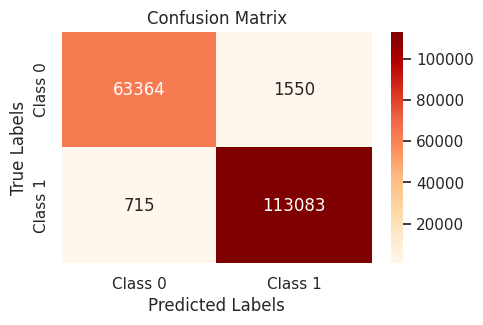

In [ ]:
df_cm = pd.DataFrame(cnfMatrix, ['Class 0','Class 1'], ['Class 0','Class 1'])
fig=plt.figure(figsize=(5,3))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},fmt='g', cmap="OrRd") # font size
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')